# Light Curves in single band at LSSTComCamSim

- author Sylvie Dagoret-Campagne (from Lauren macArthur)
- creation date 2024-05-18
- last update 2024-05-19

w_2024_16
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/


In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

In [2]:
#xx-small
#x-small
#small
#medium
#large
#x-large
#xx-large

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [3]:
saveDir = "./"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [4]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux = 100

In [5]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collectionn = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
#collections = [collection1,collection2,collection3]
collections = [collection2]
collection = collection2
collectionStr = collectionn.replace("/", "_")
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
#3533 : No matching visitId
tract = 2494
#tract = 7445
#tract = 9880
band = "i"
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

calibFluxStr = "apFlux_12_0_instFlux"
calibFluxErrStr = "apFlux_12_0_instFluxErr"
calibFluxMagStr = "apFlux_12_0_instMag"
calibFluxMagErrStr = "apFlux_12_0_instMagErr"

calibFluxCalStr = "apFlux_12_0_calFlux"
calibFluxCalErrStr = "apFlux_12_0_calFluxErr"
calibFluxCalMagStr = "apFlux_12_0_calMag"
calibFluxCalMagErrStr = "apFlux_12_0_calMagErr"

file_output_selectedsources = f"lightcurves-dmrehearsal2024_04_03_tract{tract}.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

In [6]:
!ls ../Visits

ccdVisittractpatch_LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985.csv
ccdVisittractpatch_LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv
ccdVisittractpatch_LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv
CheckSkyBGandZP_Auxtel.ipynb
CheckSkyBGandZP_LSSTComCamSim.ipynb
CheckTractsVisitsOnSky.ipynb
CheckTractsVisitsOnSky_LSSAuxtel.ipynb
CheckTractsVisitsOnSky_LSSTComCamSim.ipynb
stat_on_photom.ipynb
stat_on_visits_LSSTAuxtel.ipynb
stat_on_visits_LSSTComCamSim.ipynb


In [7]:
file_selected_visits = "../Visits/ccdVisittractpatch_LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv"

In [8]:
df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)
my_selectedvisits = list(df_myselectedvisits.index)

In [9]:
df_myselectedvisits

visitId band  detector          ra        dec       llcra  \
ccdVisitId                                                                      
730865860864  7024040300001    r         0  124.617999 -15.026212  124.458471   
730865860865  7024040300001    r         1  124.745824 -14.826505  124.586453   
730865860866  7024040300001    r         2  124.873418 -14.626731  124.714213   
730865860867  7024040300001    r         3  124.824851 -15.149693  124.665250   
730865860868  7024040300001    r         4  124.952564 -14.949870  124.793126   
...                     ...  ...       ...         ...        ...         ...   
730866060292  7024040300780    r         4  299.857944 -40.858541  299.648263   
730866060293  7024040300780    r         5  300.072069 -40.688646  299.862940   
730866060294  7024040300780    r         6  299.867703 -41.190589  299.656968   
730866060295  7024040300780    r         7  300.082879 -41.020682  299.872697   
730866060296  7024040300780    r         8  300.296939 -40.850372  300.087328   

                 llcdec       ulcra     ulcdec       urcra     urcdec  \
ccdVisitId                                                              
730865860864 -15.063877  124.581823 -14.871498  124.777487 -14.988434   
730865860865 -14.864268  124.709592 -14.671812  124.905148 -14.788632   
730865860866 -14.664580  124.837124 -14.472080  125.032570 -14.588777   
730865860867 -15.187500  124.788499 -14.995008  124.984403 -15.111770   
730865860868 -14.987773  124.916155 -14.795198  125.111945 -14.911856   
...                 ...         ...        ...         ...        ...   
730866060292 -40.863270  299.855183 -40.699906  300.067595 -40.853432   
730866060293 -40.693761  300.068800 -40.530029  300.281152 -40.683155   
730866060294 -41.195332  299.864904 -41.031966  300.078406 -41.185459   
730866060295 -41.025821  300.079575 -40.862055  300.293012 -41.015162   
730866060296 -40.855895  300.293126 -40.691757  300.506492 -40.844470   

                   lrcra     lrcdec  ccdVid  Vid  nightObs  tractID  patchID  \
ccdVisitId                                                                     
730865860864  124.654231 -15.180921       0    0  20240403     6914      246   
730865860865  124.782113 -14.981198       1    0  20240403     7149       12   
730865860866  124.909767 -14.781395       2    0  20240403     7149       61   
730865860867  124.861257 -15.304366       3    0  20240403     6914      227   
730865860868  124.989026 -15.104533       4    0  20240403     6914      259   
...                  ...        ...     ...  ...       ...      ...      ...   
730866060292  299.860717 -41.017175  199428  779  20240403     3384      159   
730866060293  300.075350 -40.847272  199429  779  20240403     3384      175   
730866060294  299.870518 -41.349193  199430  779  20240403     3384       91   
730866060295  300.086197 -41.179299  199431  779  20240403     3384      124   
730866060296  300.300763 -41.008987  199432  779  20240403     3384      156   

              zeroPoint   airmass      skyBg   skyNoise  expTime  
ccdVisitId                                                        
730865860864  31.258871  1.050426  1703.7678  34.471790     30.0  
730865860865  31.238535  1.051820  1674.7633  32.659890     30.0  
730865860866  31.259706  1.053236  1709.5557  33.396534     30.0  
730865860867  31.267454  1.050393  1717.0840  34.223988     30.0  
730865860868  31.265049  1.051787  1714.5277  33.346077     30.0  
...                 ...       ...        ...        ...      ...  
730866060292  31.276102  1.063331  1544.4893  31.839106     30.0  
730866060293  31.241217  1.063830  1498.4359  32.142555     30.0  
730866060294  31.276382  1.064358  1540.6070  32.586014     30.0  
730866060295  31.260756  1.064839  1523.1494  31.984844     30.0  
730866060296  31.251465  1.065340  1514.5978  32.967434     30.0  

[6301 rows x 23 columns]

In [10]:
# Testing on an HSC RC2 run
# butlerRoot = "/repo/main"
# collection = "HSC/runs/RC2/w_2024_06/DM-42797"

# collectionStr = collection.replace("/", "_")
# instrument = "HSC"
# skymapName = "hsc_rings_v1"
# band = "i"
# tract = 9813

# calibFluxStr = "apFlux_12_0_instFlux"

In [11]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collection = {}".format(collection))

camera_name = LSSTComCamSim
collection = LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612


### load isolated_star_sources

In [12]:
# Try to get the Schema
all_tracts = []
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= where_clause)
for i, ref in enumerate(datasetRefs):
    print(i,ref.dataId)
    all_tracts.append(ref.dataId["tract"])
    #butler_data = butler.get(ref)

all_tracts = sorted(all_tracts)
print("all tracts : ", all_tracts)

#if not isinstance(butler_data, pd.core.frame.DataFrame):
#    print(butler_data.getSchema())

0 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2494}
1 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2495}
2 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2661}
3 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 2662}
4 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3200}
5 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3345}
6 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3346}
7 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3533}
8 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 3534}
9 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 6914}
10 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 6915}
11 {instrument: 'LSSTComCamSim', skymap: 'ops_rehersal_prep_2k_v1', tract: 7148}
12 {instrument: 'LSSTComCamSim', skyma

## isolated_star_sources

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [13]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [14]:
isolatedStarSourcesFull.head()

index             sourceId          visit  detector          ra  \
0   99325  3065474226484936866  7024040300581         7  279.868189   
1  105385  3065474227558684913  7024040300582         7  279.868196   
2   99478  3065474228632420428  7024040300583         7  279.868183   
3  101480  3065474229706169087  7024040300584         7  279.868186   
4   98012  3065474230779906996  7024040300585         7  279.868187   

         dec physical_filter band  apFlux_12_0_instFlux  \
0 -48.063642            i_06    i          20825.896484   
1 -48.063645            i_06    i          20513.070312   
2 -48.063642            i_06    i          19191.630859   
3 -48.063643            i_06    i          19648.865234   
4 -48.063643            i_06    i          20019.126953   

   apFlux_12_0_instFluxErr            x            y      xErr      yErr  \
0               621.281189  3656.229531    69.944283  0.022153  0.022196   
1               621.842896  1154.947901  2758.247871  0.022588  0.021572   
2               631.030823   434.090032    36.309856  0.023069  0.023109   
3               618.939209   715.767385  3143.944998  0.023796  0.024680   
4               647.828674  1590.989654  1500.417290  0.027849  0.027534   

   apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  apFlux_17_0_flag  \
0          20419.768999               879.229880             False   
1          21523.310571               880.180357             False   
2          18530.540675               894.783943             False   
3          19133.695969               875.697264             False   
4          18883.463567               918.737462             False   

   localBackground_instFlux  localBackground_flag       ixx       iyy  \
0                  0.239154                 False  1.825126  1.816471   
1                  0.254727                 False  1.860208  1.774970   
2                 -0.643387                 False  1.817381  1.879033   
3                 -0.334094                 False  1.933969  2.048853   
4                 -2.123127                 False  2.258469  2.286982   

        ixy  source_row  obj_index  
0  0.009507       99325          0  
1 -0.005804      105385          0  
2 -0.054907       99478          0  
3  0.078023      101480          0  
4  0.012919       98012          0

In [15]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_12_0_instFlux',
       'apFlux_12_0_instFluxErr', 'x', 'y', 'xErr', 'yErr',
       'apFlux_17_0_instFlux', 'apFlux_17_0_instFluxErr', 'apFlux_17_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'ixx', 'iyy', 'ixy',
       'source_row', 'obj_index'],
      dtype='object')

## Select the visits in the preselected list

I add here my filter to select the visits I want to focus on from file_selected_visits = "../data/202402/SelectedVisits_fall2023_tract_3864.csv"
It include all bands

In [16]:
#def SelectByVisit(row):
#    if row["visit"] in my_selectedvisits:
#        return True
#    else:
#        return False

In [17]:
#isolatedStarSourcesFull["flag"] = isolatedStarSourcesFull.apply(SelectByVisit,axis=1,raw=False)

In [18]:
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["flag"]]
#isolatedStarSourcesFull.drop("flag",axis=1,inplace=True)

In [19]:
isolatedStarSourcesFull

index             sourceId          visit  detector          ra  \
0        99325  3065474226484936866  7024040300581         7  279.868189   
1       105385  3065474227558684913  7024040300582         7  279.868196   
2        99478  3065474228632420428  7024040300583         7  279.868183   
3       101480  3065474229706169087  7024040300584         7  279.868186   
4        98012  3065474230779906996  7024040300585         7  279.868187   
...        ...                  ...            ...       ...         ...   
632281   89505  3065474355329765051  7024040300701         6  279.317264   
632282   89494  3065474355329765040  7024040300701         6  279.350816   
632283    3927  3065474372484468568  7024040300717         0  279.210533   
632284   89480  3065474355329765026  7024040300701         6  279.534131   
632286   53584  3065474239357257111  7024040300593         4  279.877350   

              dec physical_filter band  apFlux_12_0_instFlux  \
0      -48.063642            i_06    i          20825.896484   
1      -48.063645            i_06    i          20513.070312   
2      -48.063642            i_06    i          19191.630859   
3      -48.063643            i_06    i          19648.865234   
4      -48.063643            i_06    i          20019.126953   
...           ...             ...  ...                   ...   
632281 -48.353042            i_06    i          12467.917969   
632282 -48.352425            i_06    i         304369.875000   
632283 -47.718853            i_06    i          12564.908203   
632284 -48.349440            i_06    i          57752.351562   
632286 -48.044490            i_06    i           6260.133301   

        apFlux_12_0_instFluxErr            x            y      xErr      yErr  \
0                    621.281189  3656.229531    69.944283  0.022153  0.022196   
1                    621.842896  1154.947901  2758.247871  0.022588  0.021572   
2                    631.030823   434.090032    36.309856  0.023069  0.023109   
3                    618.939209   715.767385  3143.944998  0.023796  0.024680   
4                    647.828674  1590.989654  1500.417290  0.027849  0.027534   
...                         ...          ...          ...       ...       ...   
632281               615.179993   431.615735  1705.250383  0.039399  0.039501   
632282               754.599121   832.976414  1701.934496  0.004069  0.004023   
632283               616.260559   239.057394  1694.350629  0.041310  0.038845   
632284               656.169617  3025.746292  1693.929139  0.011050  0.011106   
632286               617.661926   513.936273   765.365402  0.119299  0.139585   

        apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  apFlux_17_0_flag  \
0               20419.768999               879.229880             False   
1               21523.310571               880.180357             False   
2               18530.540675               894.783943             False   
3               19133.695969               875.697264             False   
4               18883.463567               918.737462             False   
...                      ...                      ...               ...   
632281          13260.117884               874.885895             False   
632282         306510.519564               980.638321             False   
632283          13155.535193               876.659606             False   
632284          56532.516058               916.630923             False   
632286           7196.736980               880.474022             False   

        localBackground_instFlux  localBackground_flag       ixx       iyy  \
0                       0.239154                 False  1.825126  1.816471   
1                       0.254727                 False  1.860208  1.774970   
2                      -0.643387                 False  1.817381  1.879033   
3                      -0.334094                 False  1.933969  2.048853   
4                      -2.123127                 False  2.25846

In [20]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

index             sourceId          visit  detector          ra        dec  \
0  99325  3065474226484936866  7024040300581         7  279.868189 -48.063642   

  physical_filter band  apFlux_12_0_instFlux  apFlux_12_0_instFluxErr  \
0            i_06    i          20825.896484               621.281189   

             x          y      xErr      yErr  apFlux_17_0_instFlux  \
0  3656.229531  69.944283  0.022153  0.022196          20419.768999   

   apFlux_17_0_instFluxErr  apFlux_17_0_flag  localBackground_instFlux  \
0                879.22988             False                  0.239154   

   localBackground_flag       ixx       iyy       ixy  source_row  obj_index  
0                 False  1.825126  1.816471  0.009507       99325          0

In [21]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_12_0_instFlux,,minSnCalibFlux = 100, minNumMatches = 3


## Select a number of visits with enough good sources in the required band

- extract the list of known objects

In [22]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched souces from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_12_0_instFlux > 100 (leaving N=72336 matched souces from original 243561)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 5298 objects from 22751).


In [23]:
sorted_visitList = sorted(visitList)
sorted_visitList[:20] 

[7024040300581,
 7024040300582,
 7024040300583,
 7024040300584,
 7024040300585,
 7024040300586,
 7024040300587,
 7024040300588,
 7024040300589,
 7024040300590,
 7024040300591,
 7024040300592,
 7024040300593,
 7024040300594,
 7024040300595,
 7024040300596,
 7024040300597,
 7024040300598,
 7024040300599,
 7024040300600]

In [24]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [25]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [26]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [27]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

In [28]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 7024040300584
sourceTable_visit not found for visit 7024040300720
Number of objects with >=3 matches before sourceTable_visit exsistence check: 5298
Number of objects with >=3 matches after sourceTable_visit exsistence check: 5293


In [29]:
visitsToRemove 

[7024040300584, 7024040300720]

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### add my info from CCD Visit Table

- CCD visit table is a pre-FGCM calibration
- it provides airmass and initial zero-point

In [30]:
# need also. ["zeroPoint","airmass"]

In [31]:
# Collect useful columns from ccdVisitTable
ccdVisitTable = butler.get("ccdVisitTable")
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + 
                                    ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)
psfSigmaDict = {}
skyBgDict = {}
skyNoiseDict = {}
expTimeDict = {}
expMidptMjdDict = {}
medianEDict = {}
psfStarScaledDeltaSizeScatterDict = {}
astromOffsetStdDict = {}
psfTraceRadiusDeltaDict = {}
zeroPointDict = {}
airmassDict = {}
# for visit in ccdVisitTable["visitId"].values:
#     if visit in visitList:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
        skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
        skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
        expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
        expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
        medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
        psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
        astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
        psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
        zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
        airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
    else:
        raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))

In [32]:
# Just to have a look at what's in the catalog:
ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

visitId physical_filter band          ra        dec  \
ccdVisitId                                                                
730865860864  7024040300001            r_03    r  124.617999 -15.026212   

              zenithDistance  zeroPoint  psfSigma        skyBg  skyNoise  \
ccdVisitId                                                                 
730865860864       17.825243  31.258871  1.507056  1703.767822  34.47179   

              astromOffsetMean  astromOffsetStd  nPsfStar  \
ccdVisitId                                                  
730865860864          0.005423         0.003085       534   

              psfStarDeltaE1Median  psfStarDeltaE2Median  \
ccdVisitId                                                 
730865860864              0.000671              0.000063   

              psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  \
ccdVisitId                                                   
730865860864               0.010385               0.010232   

              psfStarDeltaSizeMedian  psfStarDeltaSizeScatter  \
ccdVisitId                                                      
730865860864               -0.001001                 0.009205   

              psfStarScaledDeltaSizeScatter  psfTraceRadiusDelta  \
ccdVisitId                                                         
730865860864                       0.006108             0.012708   

              maxDistToNearestPsf    effTime  effTimePsfSigmaScale  \
ccdVisitId                                                           
730865860864           343.330109  11.789084              1.127149   

              effTimeSkyBgScale  effTimeZeroPointScale       decl  detector  \
ccdVisitId                                                                    
730865860864           0.344765                1.01124 -15.026212         0   

               seeing  skyRotation                   expMidpt   expMidptMJD  \
ccdVisitId                                                                    
730865860864  0.71116   121.461718 2024-04-03 23:30:29.555496  60403.979509   

              expTime                   obsStart   obsStartMJD  darkTime  \
ccdVisitId                                                                 
730865860864     30.0 2024-04-03 23:30:14.555496  60403.979335   33.0576   

              xSize  ySize       llcra     llcdec       ulcra     ulcdec  \
ccdVisitId                                                                 
730865860864   4071   3999  124.458471 -15.063877  124.581823 -14.871498   

                   urcra     urcdec       lrcra     lrcdec   airmass   medianE  
ccdVisitId                                                                      
730865860864  124.777487 -14.988434  124.654231 -15.180921  1.050426  0.000674

In [33]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_12_0_instFlux',
       'apFlux_12_0_instFluxErr', 'x', 'y', 'xErr', 'yErr',
       'apFlux_17_0_instFlux', 'apFlux_17_0_instFluxErr', 'apFlux_17_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'ixx', 'iyy', 'ixy',
       'source_row', 'obj_index'],
      dtype='object')

In [34]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)
# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.

dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]
dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [35]:
dataJoined[dataJoined.index == 0]

sourceId        psfFlux  psfFluxErr  psfFlux_flag  \
0  3065474355304595504  299905.845584  633.195352         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0         1.00002                0.0           0.0              True   

   deblend_skipped   gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  300456.638036       694.738886              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0         1.310418            0.000302                 False     47   

           visit  detector          ra        dec physical_filter band  \
0  7024040300701         0  279.299256 -47.790118            i_06    i   

   apFlux_12_0_instFlux  apFlux_12_0_instFluxErr           x          y  \
0           229203.4375               715.427795  409.312498  23.800604   

       xErr      yErr  apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  \
0  0.004702  0.004685         230923.146352               949.589539   

   apFlux_17_0_flag  localBackground_instFlux  localBackground_flag       ixx  \
0             False                  2.296231                 False  2.028315   

        iyy       ixy  source_row  obj_index       psfSn     psfMag  \
0  1.996937 -0.009543          47      13623  473.638735  17.707538   

   psfMagErr  apFlux_12_0_calFlux  apFlux_12_0_calFluxErr  apFlux_12_0_calMag  \
0   0.002292        300352.211027              937.509151           17.705923   

   apFlux_12_0_calMagErr  psfInstMag  psfGausFluxRatio  psfSigma        skyBg  \
0               0.003389   18.001062          0.998167  1.419541  1171.837891   

   expTime   expMidptMjd  nSource   medianE  psfStarScaledDeltaSizeScatter  \
0     30.0  60404.394699   108372  0.000463                       0.007491   

   astromOffsetStd  psfTraceRadiusDelta  zeroPoint   airmass  
0         0.005481             0.012611  31.106817  1.072587

## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [36]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [37]:
dataJoined[dataJoined.index == 0]

sourceId        psfFlux  psfFluxErr  psfFlux_flag  \
0  3065474355304595504  299905.845584  633.195352         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0         1.00002                0.0           0.0              True   

   deblend_skipped   gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  300456.638036       694.738886              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0         1.310418            0.000302                 False     47   

           visit  detector          ra        dec physical_filter band  \
0  7024040300701         0  279.299256 -47.790118            i_06    i   

   apFlux_12_0_instFlux  apFlux_12_0_instFluxErr           x          y  \
0           229203.4375               715.427795  409.312498  23.800604   

       xErr      yErr  apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  \
0  0.004702  0.004685         230923.146352               949.589539   

   apFlux_17_0_flag  localBackground_instFlux  localBackground_flag       ixx  \
0             False                  2.296231                 False  2.028315   

        iyy       ixy  source_row  obj_index       psfSn     psfMag  \
0  1.996937 -0.009543          47      13623  473.638735  17.707538   

   psfMagErr  apFlux_12_0_calFlux  apFlux_12_0_calFluxErr  apFlux_12_0_calMag  \
0   0.002292        300352.211027              937.509151           17.705923   

   apFlux_12_0_calMagErr  psfInstMag  psfGausFluxRatio  psfSigma        skyBg  \
0               0.003389   18.001062          0.998167  1.419541  1171.837891   

   expTime   expMidptMjd  nSource   medianE  psfStarScaledDeltaSizeScatter  \
0     30.0  60404.394699   108372  0.000463                       0.007491   

   astromOffsetStd  psfTraceRadiusDelta  zeroPoint   airmass  psfMagDiffMmag  \
0         0.005481             0.012611  31.106817  1.072587       -2.557285   

   psfMagDiffChi  raDiffMas  decDiffMas  raCosDecDiffMas  
0       -1.07636   3.326962    5.881676        23.471765

In [38]:
dataJoined.head()

sourceId        psfFlux  psfFluxErr  psfFlux_flag  \
0  3065474355304595504  299905.845584  633.195352         False   
1  3065474355304595517  128885.232005  439.861386         False   
2  3065474355304595519  305726.358927  638.874883         False   
3  3065474355304595531  151025.209791  468.332459         False   
4  3065474355304595538  156059.992787  477.596238         False   

   psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
0        1.000020                0.0           0.0              True   
1        1.000150                0.0           0.0              True   
2        1.000219                0.0           0.0              True   
3        1.000159                0.0           0.0              True   
4        0.999964                0.0           0.0              True   

   deblend_skipped   gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
0            False  300456.638036       694.738886              False   
1            False  128814.249256       452.172049              False   
2            False  305660.250852       685.349363              False   
3            False  150833.977632       484.425228              False   
4            False  156814.037573       508.699685              False   

   localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
0         1.310418            0.000302                 False     47   
1         1.311168            0.000302                 False     60   
2         1.311246            0.000302                 False     62   
3         1.311195            0.000302                 False     74   
4         1.310523            0.000302                 False     81   

           visit  detector          ra        dec physical_filter band  \
0  7024040300701         0  279.299256 -47.790118            i_06    i   
1  7024040300701         0  279.572043 -47.786567            i_06    i   
2  7024040300701         0  279.599390 -47.786091            i_06    i   
3  7024040300701         0  279.582629 -47.786746            i_06    i   
4  7024040300701         0  279.340023 -47.790387            i_06    i   

   apFlux_12_0_instFlux  apFlux_12_0_instFluxErr            x          y  \
0         229203.437500               715.427795   409.312498  23.800604   
1          98265.148438               643.768616  3707.909286  28.674824   
2         232833.171875               704.252563  4038.644921  27.651518   
3         114232.921875               651.247498  3835.796200  34.806701   
4         119501.093750               675.424805   901.999202  38.179931   

       xErr      yErr  apFlux_17_0_instFlux  apFlux_17_0_instFluxErr  \
0  0.004702  0.004685         230923.146352               949.589539   
1  0.007721  0.007607          99505.878695               886.865084   
2  0.004644  0.004588         232792.672823               931.043108   
3  0.006935  0.006928         114153.909684               890.964377   
4  0.007015  0.006831         118771.256626               922.005757   

   apFlux_17_0_flag  localBackground_instFlux  localBackground_flag       ixx  \
0             False                  2.296231                 False  2.028315   
1             False                  1.072012                 False  1.986601   
2             False                 -0.299907                 False  2.010355   
3             False                 -0.169908                 False  1.984048   
4             False                  0.186153                 False  2.060237   

        iyy       ixy  source_row  obj_index       psfSn     psfMag  \
0  1.996937 -0.009543          47      13623  473.638735  17.707538   
1  1.987002 -0.016942          60       4933  293.013290  18.624492   
2  1.959076 -0.030648          62       4571  478.538705  17.686668   
3  1.978598  0.005924          74       5122  322.474360  18.452376   
4  1.987539 -0.003292          81      10872  326.761353  18.416771   

   psfMagErr  apFlux_12_0_calFlux  apFlux_12_0_calFluxErr  apFl

## Plot the per object source 

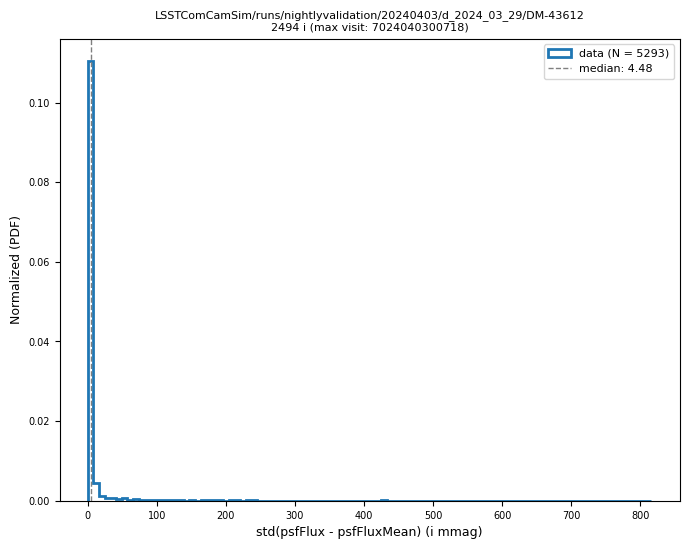

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
#nBins = 16 if len(dataJoined) < 4000 else 100
nBins = 32 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

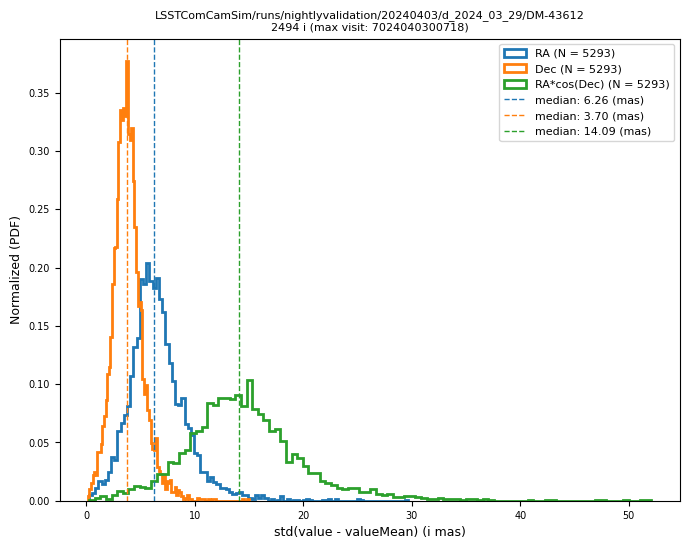

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

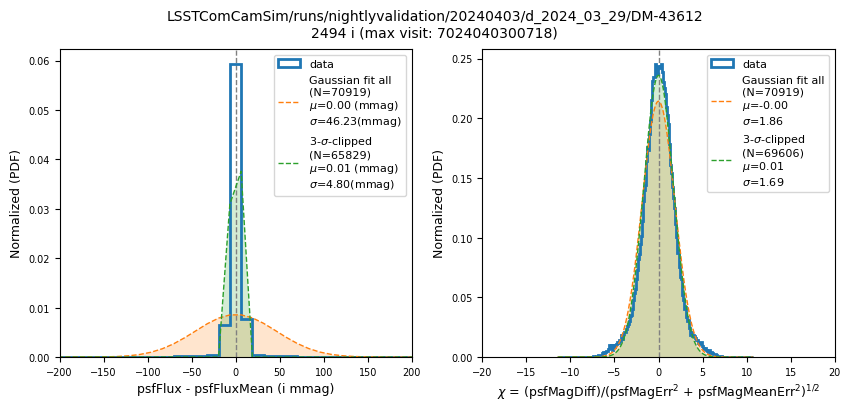

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-200, 200)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

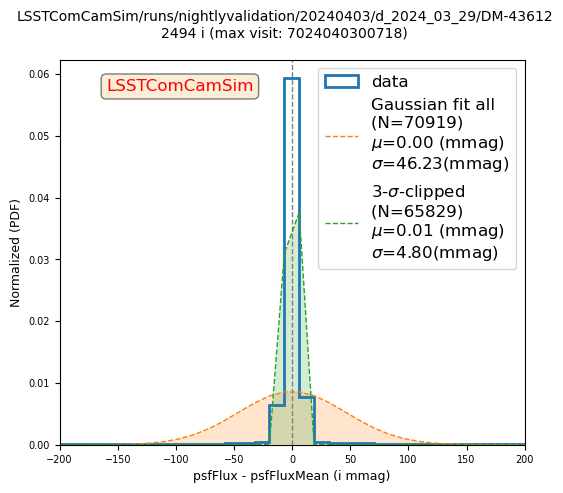

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,5))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-200, 200)
ax1.legend(fontsize=12,loc="upper right")
ax1.text(0.1, 0.95, "LSSTComCamSim", transform=ax1.transAxes, fontsize=12,color="red",verticalalignment='top', bbox=props)
figname = f"photomrepeat_band_{band}_LSSTComCamSim.png"
plt.savefig(figname)
plt.show()

In [43]:
Band_To_Cmap_Dict = {"g":plt.cm.Greens,"r":plt.cm.Reds,"i":plt.cm.Oranges,"z":plt.cm.Purples,"y":plt.cm.Greys}

/tmp/ipykernel_66077/3215363886.py:14: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(fontsize=8)


/tmp/ipykernel_66077/3215363886.py:27: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax2.legend(fontsize=8)


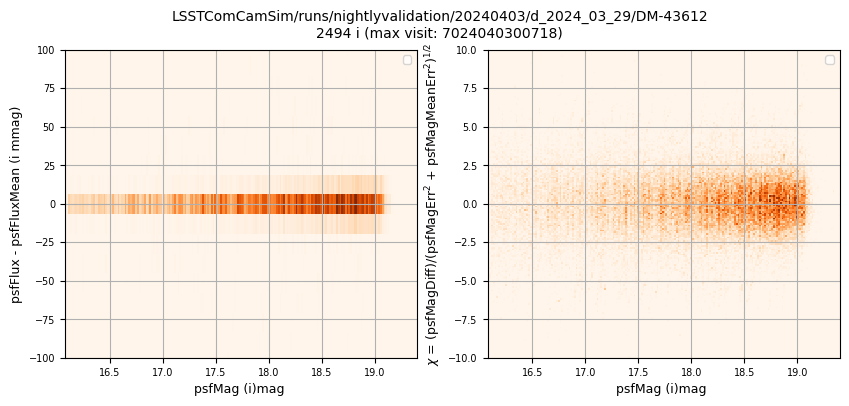

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,100), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax1.set_ylim(-100, 100)
ax1.legend(fontsize=8)
ax1.grid()

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,100),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax2.set_ylim(-10, 10)
ax2.legend(fontsize=8)
ax2.grid()

if doSaveFigs:
    filename = "{}psfFluxDiffHist2D_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [45]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

Large Std: objectIndex = 5  number of matches = 36
Large Std: objectIndex = 11  number of matches = 35
Large Std: objectIndex = 13  number of matches = 36
Large Std: objectIndex = 25  number of matches = 6
Large Std: objectIndex = 35  number of matches = 35
Large Std: objectIndex = 59  number of matches = 36
Large Std: objectIndex = 96  number of matches = 11
Large Std: objectIndex = 108  number of matches = 7
Large Std: objectIndex = 118  number of matches = 34
Large Std: objectIndex = 144  number of matches = 34
Large Std: objectIndex = 151  number of matches = 35
Large Std: objectIndex = 152  number of matches = 34
Large Std: objectIndex = 158  number of matches = 31
Large Std: objectIndex = 196  number of matches = 33
Large Std: objectIndex = 218  number of matches = 33
Large Std: objectIndex = 271  number of matches = 33
Large Std: objectIndex = 298  number of matches = 34
Large Std: objectIndex = 309  number of matches = 34
Large Std: objectIndex = 340  number of matches = 28
Lar

numObj = 3 [with obj_index = 4118]
numObj = 13 [with obj_index = 6424]
numObj = 13 [with obj_index = 7159]
numObj = 35 [with obj_index = 11]


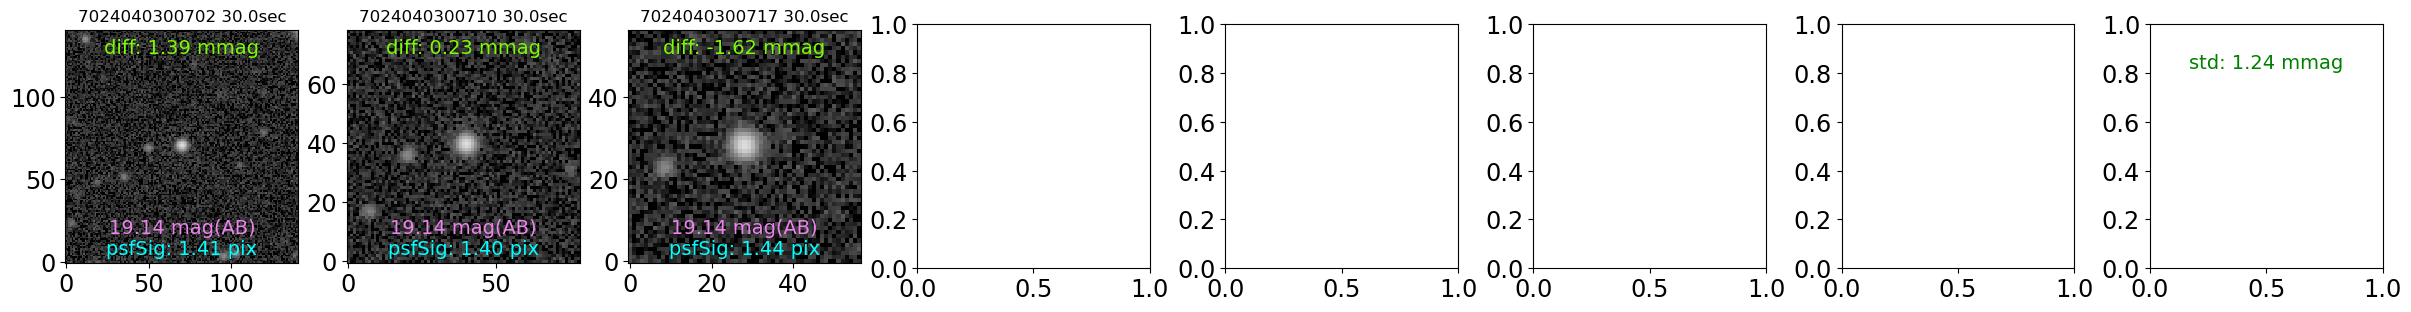

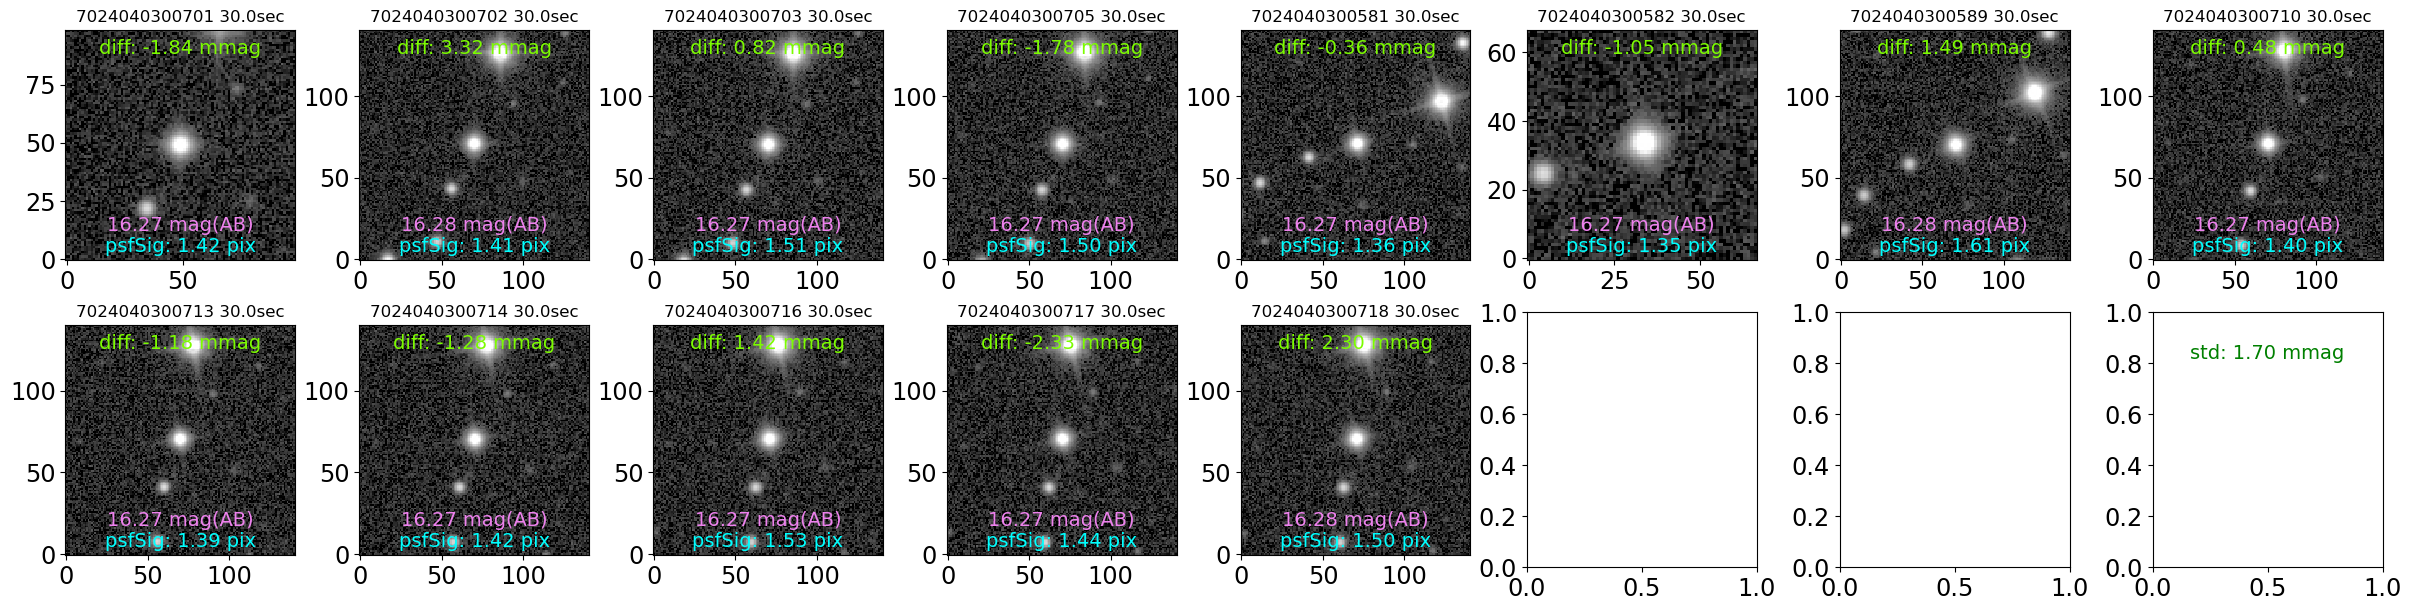

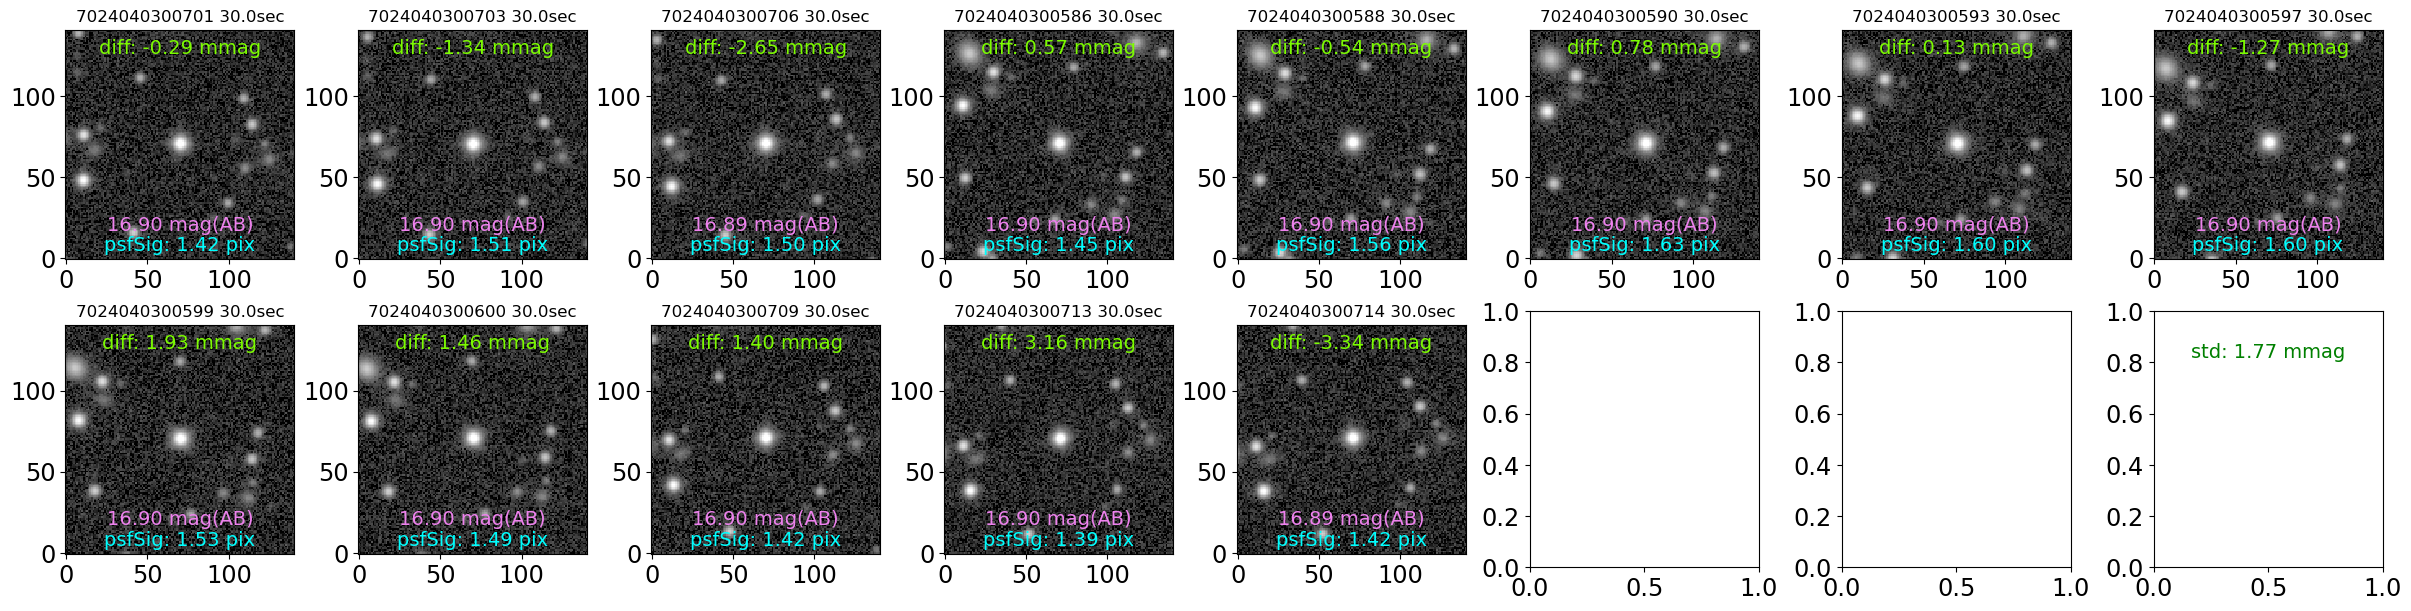

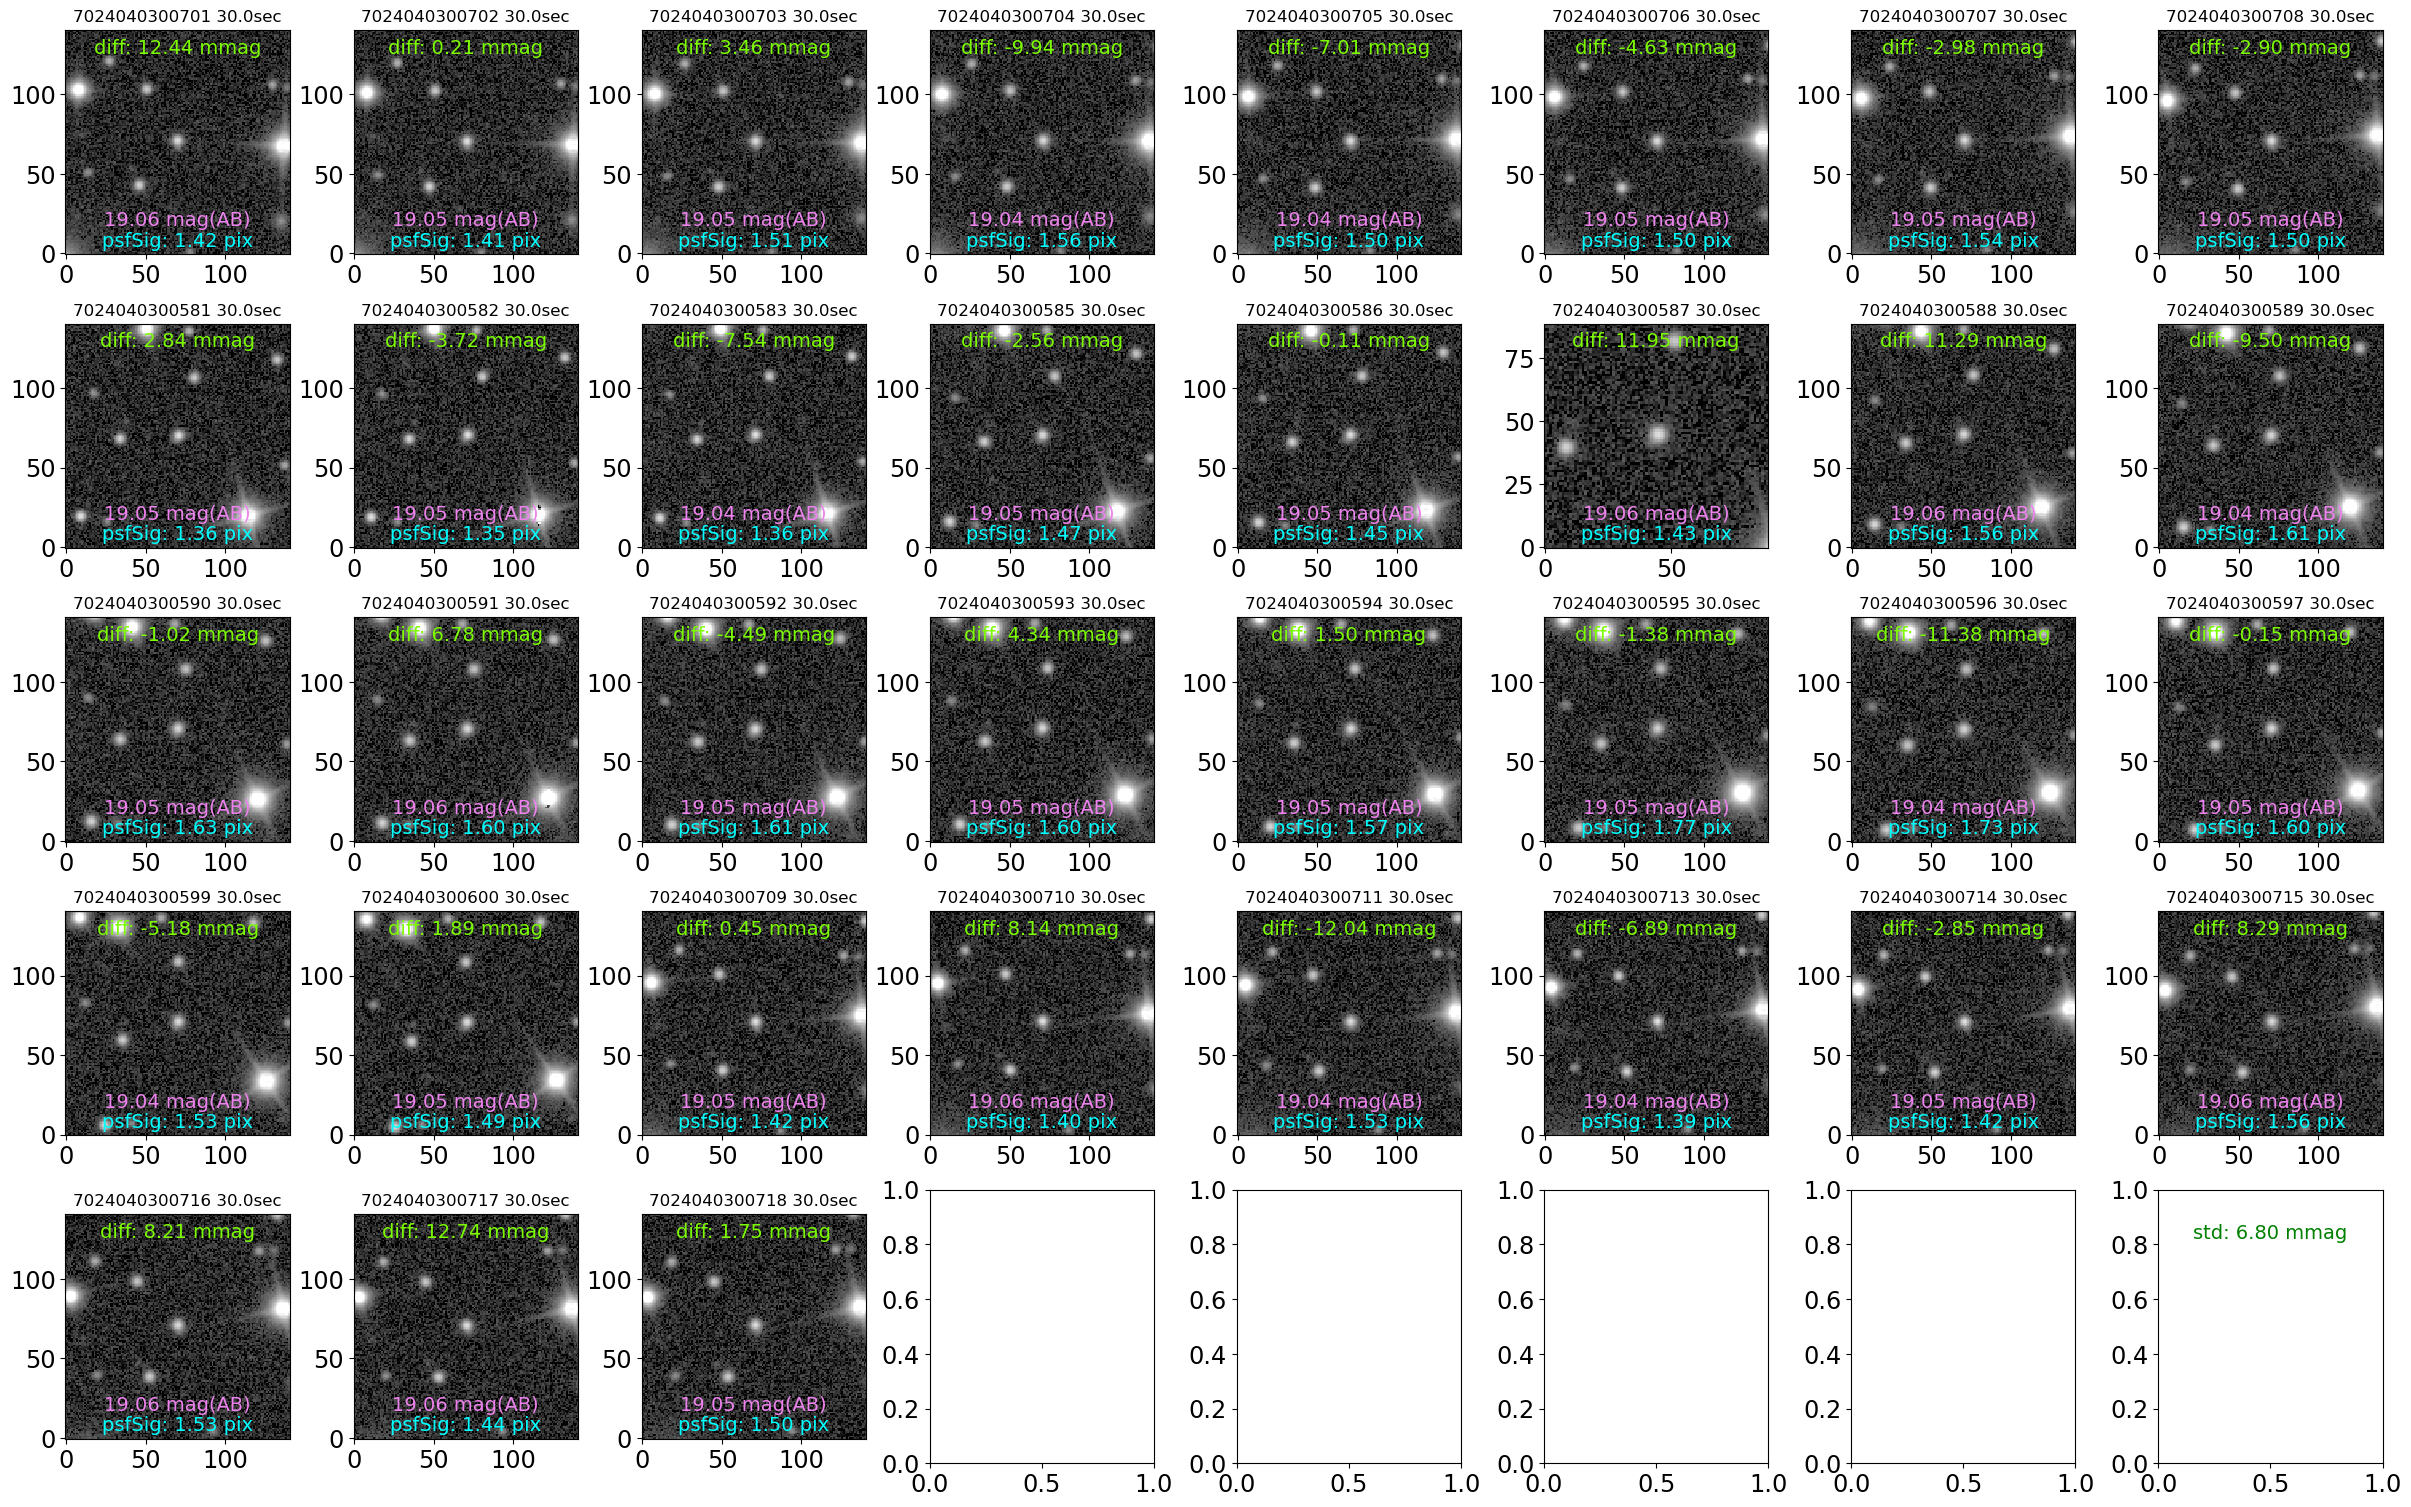

In [46]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} {}sec".format(visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

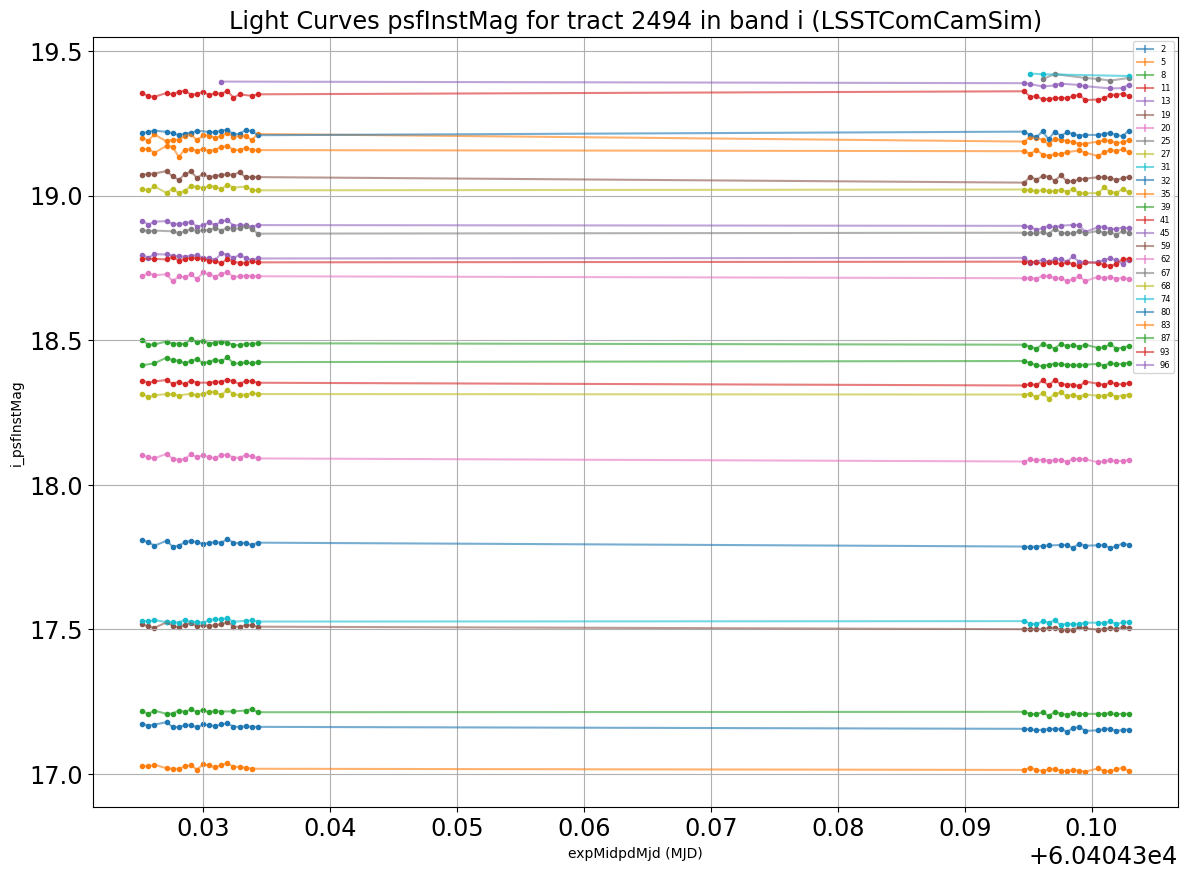

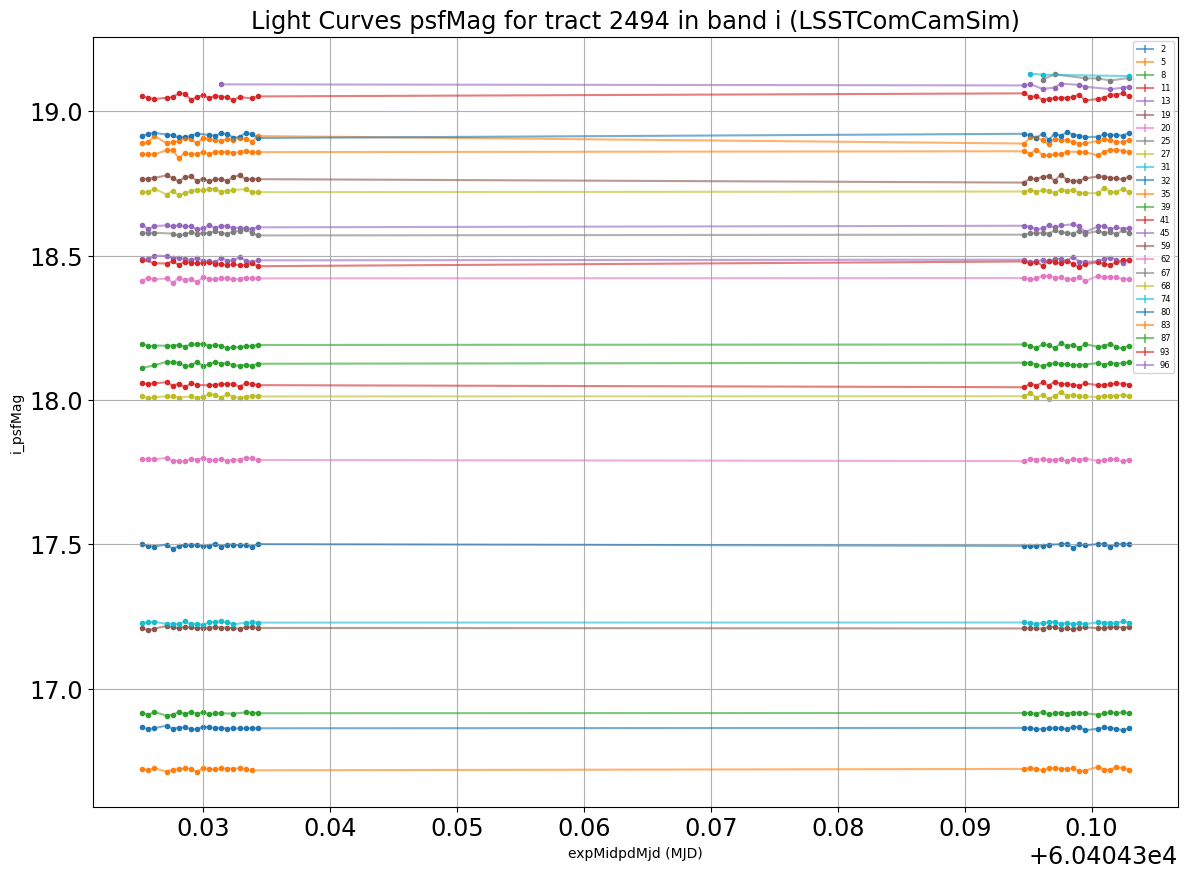

In [47]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curves {magStr} for tract {tract} in band {band} (LSSTComCamSim)"
    ax.set_title(title)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

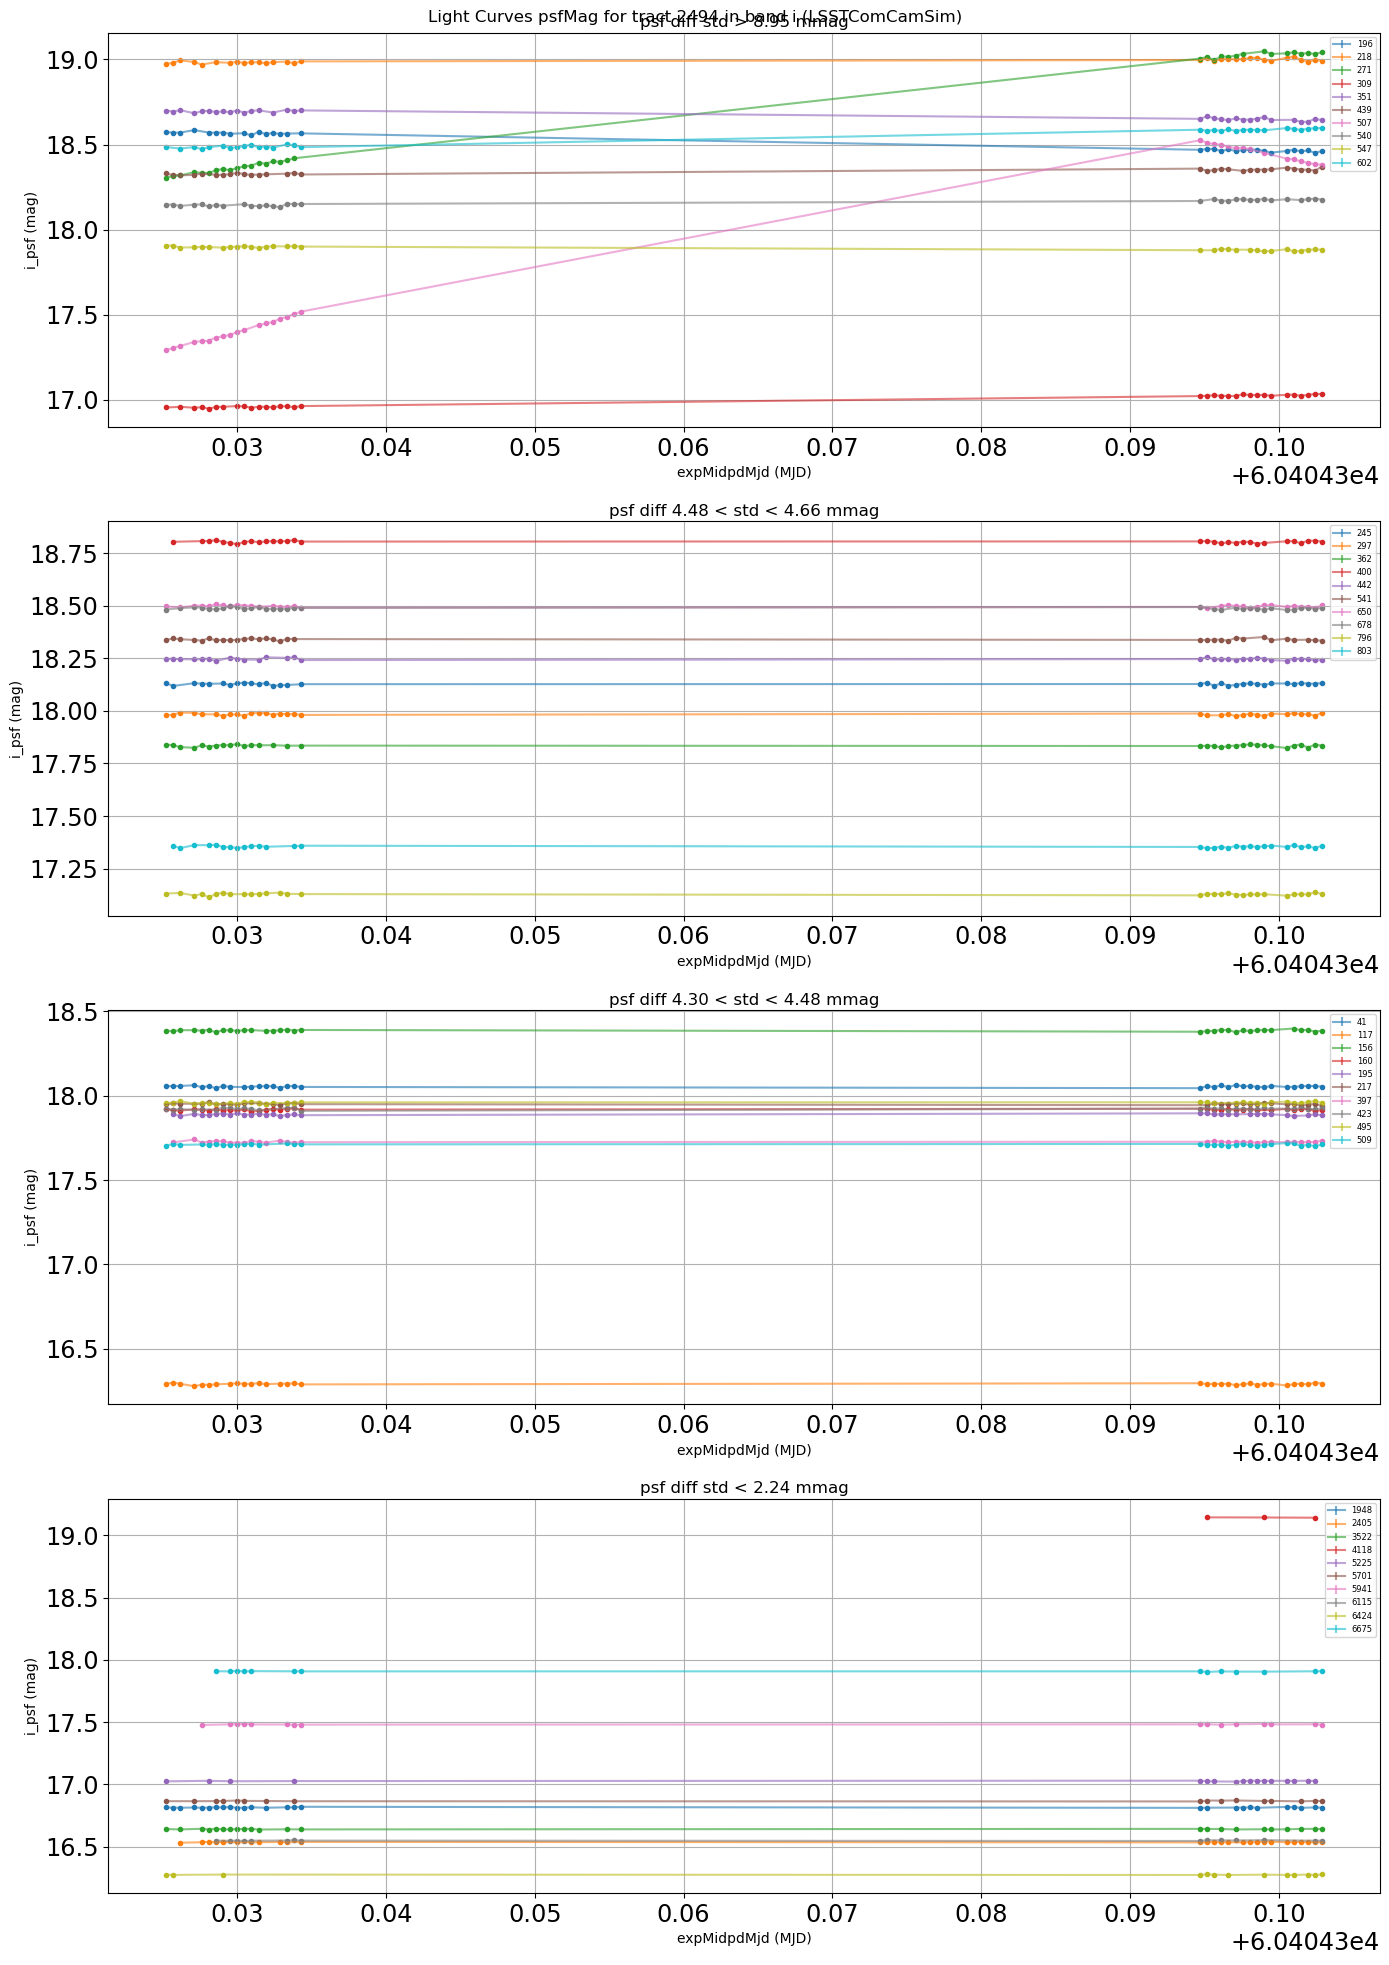

In [48]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]

fig, axes = plt.subplots(4, 1, figsize=(14, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
suptitle = f"Light Curves {magStr} for tract {tract} in band {band} (LSSTComCamSim)"
plt.suptitle(suptitle)
plt.tight_layout()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)
plt.tight_layout()